In [1]:
#| default_exp rally

# Rally

> Easily analyze a pickleball rally

In [77]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
#| export
from pklshop.data import *
from pklshop.stats import *
from pklshop.name import *
from pklshop.game import *
from pklshop.match import *
import pandas as pd
import matplotlib.pyplot as plt

In [79]:
#! Need to think about how to store these tables so that functions can use them
#! but don't want to have to pass specific tables every time
rally = get_tab_as_df("rally")
players = get_tab_as_df("player")
game = get_tab_as_df("game")
team = get_tab_as_df("team")
match = get_tab_as_df("match")
tournament = get_tab_as_df("tournament") 
shots = get_tab_as_df("shot")

In [397]:
def plot_court():
        plt.figure(figsize=(5,5.5))
        plt.xlim(-2.5, 22.5)
        plt.ylim(-24.5, 24.5)

        # Draw the court and non-volley zone
        plt.fill_between([0, 20], [-22, -22], [22, 22], color='darkblue', alpha=0.5)
        plt.fill_between([0, 20], [-7, -7], [7, 7], color='green', alpha=0.5)

        #Draw lines
        plt.plot([10, 10], [7.1, 22], color='white', linestyle='-', linewidth=1.5)
        plt.plot([10, 10], [-7.1, -22], color='white', linestyle='-', linewidth=1.5)
        plt.plot([0, 0], [-22, 22], color='white', linestyle='-', linewidth=2)
        plt.plot([20, 20], [-22, 22], color='white', linestyle='-', linewidth=2)
        plt.plot([0, 20], [22, 22], color='white', linestyle='-', linewidth=2)
        plt.plot([0, 20], [-22, -22], color='white', linestyle='-', linewidth=2)
        plt.plot([0, 20], [7, 7], color='white', linestyle='-', linewidth=2)
        plt.plot([0, 20], [-7, -7], color='white', linestyle='-', linewidth=2)

        #Draw net
        plt.plot([-0.5, 20.5], [0, 0], color='black', linestyle='-', linewidth=2)

        ax = plt.gca()
        ax.set_facecolor('lightblue')

In [476]:
#| export
class Rally:
    def __init__(self, rally_id: str):
        self.rally_id= rally_id
        self.rally = rally[rally.rally_id == rally_id] # todo catch invalid rally number
        self.rally_len = len(self.rally)
        self.shots = shots[shots.rally_id == rally_id]
        self.xcoords = self.shots.sort_values("shot_nbr").loc_x
        self.ycoords = self.shots.sort_values("shot_nbr").loc_y
        # self.game_id = self.rally.game_id.iloc[0]
        # self.match_id = self.rally.match_id.iloc[0]
    
    def __str__(self):
        return f"Rally {self.rally_id}"
    __repr__ = __str__

    def plot_rally(self):
        y_arr = []
        n = range(1, len(self.xcoords) + 1)
        for i, y in enumerate(self.ycoords):
            #Reverse the y location of every other shot
            if i % 2 == 0:
                y_arr.append(y)
            else:
                y_arr.append(-y) 

        plt.figure(figsize=(5,5.5))

        plot_court()

        for xi, yi, txt in zip(self.xcoords, y_arr, n):
            if len(str(txt)) == 1:
                size=100
            else:
                size=200
            plt.scatter(xi, yi, marker=f'${txt}$', color='red', s=size, zorder=2)
            
        plt.xlim(-2.5, 22.5)
        plt.ylim(-24.5, 24.5)
    
        plt.show()

In [477]:
r = Rally("R1008")

In [478]:
r.shots.sort_values("shot_nbr").head()

,shot_id,rally_id,shot_nbr,shot_type_orig,shot_type,player_id,entry_ts,btt_before,btt_after,loc_x,loc_y,next_loc_x,next_loc_y,shot_type_model_id,whtb_model_id,maint_dtm,maint_app,create_dtm,create_app
11369,S10638,R1008,1,SE,None,P6,2022-08-16 17:01:27.133022,None,0.4615,13.30,21.31,19.61,21.66,None,None,2022-08-16 21:22:01.386613+00:00,postgres,2022-08-16 21:22:01.386613+00:00,postgres
11370,S10639,R1008,2,R,None,P23,2022-08-16 17:01:29.760983,0.4615,0.5809,19.61,21.66,7.12,20.63,None,None,2022-08-16 21:22:01.387597+00:00,postgres,2022-08-16 21:22:01.387597+00:00,postgres
11371,S10640,R1008,3,tsDrv,None,P6,2022-08-16 17:01:32.891239,0.5809,0.0913,7.12,20.63,5.97,5.50,None,None,2022-08-16 21:22:01.388583+00:00,postgres,2022-08-16 21:22:01.388583+00:00,postgres
821,S10641,R1008,4,O,tzRep,P13,2022-08-16 17:01:33.960504,0.0913,0.0863,5.97,5.50,13.42,7.22,Classify_Other_Shots_StackedEnsemble_BestOfFam...,WWTB_ClassifierDRF_1_AutoML_1_20221108_171453.zip,2022-11-08 23:25:58.791397+00:00,postgres,2022-08-16 21:22:01.389578+00:00,postgres
822,S10642,R1008,5,O,tzApp,P24,2022-08-16 17:01:35.008702,0.0863,0.0362,13.42,7.22,5.86,7.33,Classify_Other_Shots_StackedEnsemble_BestOfFam...,WWTB_ClassifierDRF_1_AutoML_1_20221108_171453.zip,2022-11-08 23:25:58.791397+00:00,postgres,2022-08-16 21:22:01.390554+00:00,postgres


<Figure size 500x550 with 0 Axes>

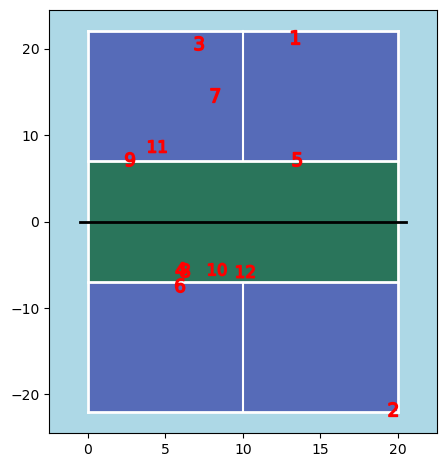

In [479]:
r.plot_rally()

In [333]:
shots.columns

Index(['shot_id', 'rally_id', 'shot_nbr', 'shot_type_orig', 'shot_type',
       'player_id', 'entry_ts', 'btt_before', 'btt_after', 'loc_x', 'loc_y',
       'next_loc_x', 'next_loc_y', 'shot_type_model_id', 'whtb_model_id',
       'maint_dtm', 'maint_app', 'create_dtm', 'create_app'],
      dtype='object')

In [32]:
r.rally.columns

Index(['rally_id', 'match_id', 'game_id', 'rally_nbr', 'srv_team_id',
       'srv_player_id', 'rtrn_team_id', 'rtrn_player_id', 'ts_player_id',
       'ts_type', 'w_team_id', 'to_ind', 'to_team_id', 'rally_len',
       'srv_switch_ind', 'rtrn_switch_ind', 'srv_team_flipped_ind',
       'rtrn_team_flipped_ind', 'ending_type', 'ending_player_id', 'lob_cnt',
       'dink_cnt', 'maint_dtm', 'maint_app', 'create_dtm', 'create_app'],
      dtype='object')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()